In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data_with_n_basket_Preprocessed_02_181002.csv', index_col=0, engine='c')
print('unique users:', len(list(set(data.user_id.values))))
print('unique items:', len(list(set(data.product_id.values))))

unique users: 7716
unique items: 9073


# RNN

In [2]:
data.head()

,user_id,order_id,order_number,product_id,reordered
10356,76,3045366,1,246,0
10357,76,3045366,1,36107,0
10358,76,1522904,2,36107,1
10362,76,1934930,3,11984,0
10363,76,1934930,3,34058,0


In [3]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
unique_item = sorted(data.product_id.unique())
item_id = array(unique_item)
print('item_id', item_id)

label_encoder = LabelEncoder()
item_idx = label_encoder.fit_transform(item_id)
print('item_idx',item_idx)

item_id [    1    10    23 ... 49655 49667 49680]
item_idx [   0    1    2 ... 9070 9071 9072]


In [5]:
print('making item2idx, idx2item and item_one_hot')
item2idx = {n: i for i, n in enumerate(item_id)}
idx2item = {i: n for i, n in enumerate(item_id)}

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = item_idx.reshape(len(item_idx), 1)
item_onehot = onehot_encoder.fit_transform(integer_encoded)

list_product = data.groupby(['user_id', 'order_id', 'order_number']).agg({'product_id':lambda x: (set(x))})
list_product = pd.DataFrame(list_product.reset_index())
list_product.columns = ['user_id', 'order_id', 'order_number', 'list_item_basket']
list_product = list_product.sort_values(['user_id', 'order_number'])
list_product = list_product.reset_index(drop=True)
list_product.head()

making item2idx, idx2item and item_one_hot


,user_id,order_id,order_number,list_item_basket
0,76,3045366,1,"{36107, 246}"
1,76,1522904,2,{36107}
2,76,1934930,3,"{11984, 34058, 46413}"
3,76,1491175,4,"{25706, 6631}"
4,76,2102068,5,{36107}


In [6]:
DF = list_product[list_product.order_number <= 10]
print('User_id, Order_id, Order_number(1~10), bakset`s item list', DF.shape)

User_id, Order_id, Order_number(1~10), bakset`s item list (77160, 4)


In [7]:
basket_multihot_list = []

for i in range(DF.shape[0]):
    session2hot = np.zeros(len(item_onehot))
    for j in list(DF.list_item_basket[i]):
        session2hot = np.add(session2hot, item_onehot[item2idx[j]])
    basket_multihot_list.append(session2hot)
print('basket_multihot_list 개수', len(basket_multihot_list))
DF['basket2vec'] = basket_multihot_list
DF.columns

basket_multihot_list 개수 77160


Index(['user_id', 'order_id', 'order_number', 'list_item_basket',
       'basket2vec'],
      dtype='object')

In [8]:
for i in range(5):
    DF['input_{}'.format(i)] = DF.groupby(['user_id'])['basket2vec'].shift(i)

df = DF[['user_id', 'order_id','order_number',  'input_4','input_3','input_2','input_1','input_0']].dropna()
df = df.reset_index(drop=True)
df.columns = ['user_id', 'order_id', 'order_number', 'input_t-4','input_t-3','input_t-2', 'input_t-1', 'output']

df[df.user_id == 76]

,user_id,order_id,order_number,input_t-4,input_t-3,input_t-2,input_t-1,output
0,76,2102068,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,76,2763506,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,76,2792895,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,76,1474394,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,76,380972,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,76,3294399,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
df['order_cnt'] = df.order_number-4
df = df[['user_id', 'order_id', 'input_t-4','input_t-3','input_t-2', 'input_t-1', 'output', 'order_cnt']]
df[df.user_id==76]

,user_id,order_id,input_t-4,input_t-3,input_t-2,input_t-1,output,order_cnt
0,76,2102068,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,76,2763506,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
2,76,2792895,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,76,1474394,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,76,380972,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
5,76,3294399,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6


In [10]:
del  data

# Basic Model [train 1~5, predict 6th basket]

In [11]:
# split into train and test sets
train = df[df.order_cnt <= 1]
test = df[df.order_cnt ==2]
print(train.shape, test.shape)

(7716, 8) (7716, 8)


In [12]:
x_train = train.drop(['order_id', 'output'], axis=1).set_index('user_id')
y_train = train[[ 'output']]
X_train=x_train.values
Y_train=y_train.values
print('X_train', X_train.shape, 'Y_train', Y_train.shape)
print('X_train[0]', X_train[0].shape)

X_train (7716, 5) Y_train (7716, 1)
X_train[0] (5,)


In [13]:
X_train_array = []
N_total_train_session = X_train.shape[0]
for j in range(N_total_train_session):
    for i in range(4): #n_step size 
        X_train_array.append(np.asarray(X_train[j][i]))
        
X_train_array = np.array(X_train_array)
X_train_array = X_train_array.reshape(N_total_train_session, 4, len(item2idx))
print('학습X', X_train_array.shape)

Y_train_array = []
for i in range(N_total_train_session):
    Y_train_array.append(np.asarray(Y_train[i][0]))

Y_train_array=np.array(Y_train_array)
print('학습Y',  Y_train_array.shape)

학습X (7716, 4, 9073)
학습Y (7716, 9073)


In [14]:
#실험 Y 
test_y  = test[['user_id','output']]
display(test_y.head(3)) 

,user_id,output
1,76,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,126,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,131,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras.utils import np_utils
import keras.backend as K 
from keras.optimizers import SGD

Using TensorFlow backend.


# Optimizer 비교 - default structure only

In [78]:
K.clear_session()

my_opt_sgd = SGD(lr=0.1)

model_LSTM_100_OPT01 = Sequential()
model_LSTM_100_OPT01.add(LSTM(100, input_shape = (4, len(item2idx)))) #input_shape=(timesteps, data_dim)
model_LSTM_100_OPT01.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT01.summary()
model_LSTM_100_OPT01.compile(loss='categorical_crossentropy', optimizer=my_opt_sgd, metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________


In [79]:
history_LSTM_100_OPT01 = model_LSTM_100_OPT01.fit(X_train_array, Y_train_array, epochs=50, batch_size=20, verbose=2)

Epoch 1/50
 - 9s - loss: 74.2871 - categorical_accuracy: 0.0080
Epoch 2/50
 - 8s - loss: 69.5880 - categorical_accuracy: 0.0039
Epoch 3/50
 - 8s - loss: 68.9796 - categorical_accuracy: 0.0038
Epoch 4/50
 - 8s - loss: 68.6724 - categorical_accuracy: 0.0031
Epoch 5/50
 - 8s - loss: 68.3287 - categorical_accuracy: 0.0054
Epoch 6/50
 - 8s - loss: 67.5509 - categorical_accuracy: 0.0089
Epoch 7/50
 - 8s - loss: 66.8032 - categorical_accuracy: 0.0114
Epoch 8/50
 - 8s - loss: 66.1384 - categorical_accuracy: 0.0136
Epoch 9/50
 - 8s - loss: 65.3649 - categorical_accuracy: 0.0227
Epoch 10/50
 - 8s - loss: 64.4350 - categorical_accuracy: 0.0302
Epoch 11/50
 - 8s - loss: 63.4056 - categorical_accuracy: 0.0358
Epoch 12/50
 - 8s - loss: 62.2992 - categorical_accuracy: 0.0428
Epoch 13/50
 - 8s - loss: 61.1040 - categorical_accuracy: 0.0500
Epoch 14/50
 - 8s - loss: 59.8559 - categorical_accuracy: 0.0557
Epoch 15/50
 - 8s - loss: 58.5367 - categorical_accuracy: 0.0642
Epoch 16/50
 - 8s - loss: 57.2138 

In [80]:
model_LSTM_100_OPT01.save('181024_model_LSTM_100h_OPT01_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT01.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT01.history, handle)

In [16]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT01.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT01 = load(handle)

In [82]:
K.clear_session()

from keras import optimizers 
momentum = optimizers.SGD(lr=0.1, momentum=0.9)

model_LSTM_100_OPT02 = Sequential()
model_LSTM_100_OPT02.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT02.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT02.summary()
model_LSTM_100_OPT02.compile(loss='categorical_crossentropy', optimizer=momentum, metrics=['categorical_accuracy'])
history_LSTM_100_OPT02 =model_LSTM_100_OPT02.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 10s - loss: 70.4666 - categorical_accuracy: 0.0041
Epoch 2/50
 - 10s - loss: 66.9467 - categorical_accuracy: 0.0163
Epoch 3/50
 - 10s - loss: 64.3533 - categorical_accuracy: 0.0351
Epoch 4/50
 - 10s - loss: 61.4376 - categorical_accuracy: 0.0461
Epoch 5/50
 - 10s - loss: 58.0966 - categorical_accuracy: 0.0592
Epoch 6/50
 - 10s - loss: 54.2965 - categorical_accuracy: 0.0697
Epoch 7/50
 - 10s - loss: 50.2233 - categorical_accuracy: 0.0837
Epoch 8/50
 - 10s - loss: 45.9923 - categorical_accuracy: 0.1024
Epoch 9/

In [83]:
model_LSTM_100_OPT02.save('181024_model_LSTM_100h_OPT02_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT02.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT02.history, handle)

In [17]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT02.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT02 = load(handle)

In [85]:
K.clear_session()

nag = optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)

model_LSTM_100_OPT03 = Sequential()
model_LSTM_100_OPT03.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT03.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT03.summary()
model_LSTM_100_OPT03.compile(loss='categorical_crossentropy', optimizer=nag, metrics=['categorical_accuracy'])
history_LSTM_100_OPT03 =model_LSTM_100_OPT03.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 10s - loss: 70.4004 - categorical_accuracy: 0.0029
Epoch 2/50
 - 10s - loss: 66.8334 - categorical_accuracy: 0.0158
Epoch 3/50
 - 10s - loss: 64.0126 - categorical_accuracy: 0.0386
Epoch 4/50
 - 10s - loss: 60.8198 - categorical_accuracy: 0.0522
Epoch 5/50
 - 10s - loss: 57.0351 - categorical_accuracy: 0.0601
Epoch 6/50
 - 10s - loss: 52.7708 - categorical_accuracy: 0.0775
Epoch 7/50
 - 10s - loss: 48.1599 - categorical_accuracy: 0.0920
Epoch 8/50
 - 10s - loss: 44.0535 - categorical_accuracy: 0.1166
Epoch 9/

In [86]:
model_LSTM_100_OPT03.save('181024_model_LSTM_100h_OPT03_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT03.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT03.history, handle)

In [18]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT03.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT03 = load(handle)

In [88]:
K.clear_session()

adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-6)

model_LSTM_100_OPT04 = Sequential()
model_LSTM_100_OPT04.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT04.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT04.summary()
model_LSTM_100_OPT04.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['categorical_accuracy'])
history_LSTM_100_OPT04 =model_LSTM_100_OPT04.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 9s - loss: 70.1601 - categorical_accuracy: 0.0018
Epoch 2/50
 - 8s - loss: 67.4389 - categorical_accuracy: 0.0130
Epoch 3/50
 - 8s - loss: 65.7732 - categorical_accuracy: 0.0161
Epoch 4/50
 - 8s - loss: 64.7185 - categorical_accuracy: 0.0189
Epoch 5/50
 - 8s - loss: 63.9682 - categorical_accuracy: 0.0205
Epoch 6/50
 - 8s - loss: 63.3083 - categorical_accuracy: 0.0245
Epoch 7/50
 - 8s - loss: 62.6498 - categorical_accuracy: 0.0271
Epoch 8/50
 - 8s - loss: 61.9805 - categorical_accuracy: 0.0299
Epoch 9/50
 - 8s

In [89]:
model_LSTM_100_OPT04.save('181024_model_LSTM_100h_OPT04_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT04.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT04.history, handle)

In [19]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT04.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT04 = load(handle)

In [91]:
K.clear_session()

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model_LSTM_100_OPT05 = Sequential()
model_LSTM_100_OPT05.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT05.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT05.summary()
model_LSTM_100_OPT05.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['categorical_accuracy'])
history_LSTM_100_OPT05 =model_LSTM_100_OPT05.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 9s - loss: 70.1323 - categorical_accuracy: 0.0064
Epoch 2/50
 - 9s - loss: 68.1619 - categorical_accuracy: 0.0096
Epoch 3/50
 - 8s - loss: 66.6566 - categorical_accuracy: 0.0165
Epoch 4/50
 - 9s - loss: 66.0582 - categorical_accuracy: 0.0241
Epoch 5/50
 - 9s - loss: 65.2983 - categorical_accuracy: 0.0314
Epoch 6/50
 - 9s - loss: 64.4897 - categorical_accuracy: 0.0406
Epoch 7/50
 - 8s - loss: 63.4480 - categorical_accuracy: 0.0494
Epoch 8/50
 - 9s - loss: 62.2209 - categorical_accuracy: 0.0588
Epoch 9/50
 - 9s

In [92]:
model_LSTM_100_OPT05.save('181024_model_LSTM_100h_OPT05_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT05.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT05.history, handle)

In [20]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT05.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT05 = load(handle)

In [94]:
K.clear_session()

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                      epsilon=None, decay=0.0, amsgrad=False)

model_LSTM_100_OPT06 = Sequential()
model_LSTM_100_OPT06.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT06.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT06.summary()
model_LSTM_100_OPT06.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])
history_LSTM_100_OPT06 =model_LSTM_100_OPT06.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 11s - loss: 70.5743 - categorical_accuracy: 0.0053
Epoch 2/50
 - 10s - loss: 67.3301 - categorical_accuracy: 0.0122
Epoch 3/50
 - 10s - loss: 65.0456 - categorical_accuracy: 0.0184
Epoch 4/50
 - 10s - loss: 63.2046 - categorical_accuracy: 0.0273
Epoch 5/50
 - 10s - loss: 60.9055 - categorical_accuracy: 0.0362
Epoch 6/50
 - 10s - loss: 57.7495 - categorical_accuracy: 0.0591
Epoch 7/50
 - 10s - loss: 54.0581 - categorical_accuracy: 0.0863
Epoch 8/50
 - 10s - loss: 50.2045 - categorical_accuracy: 0.1135
Epoch 9/

In [95]:
model_LSTM_100_OPT06.save('181024_model_LSTM_100h_OPT06_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT06.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT06.history, handle)

In [21]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT06.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT06 = load(handle)

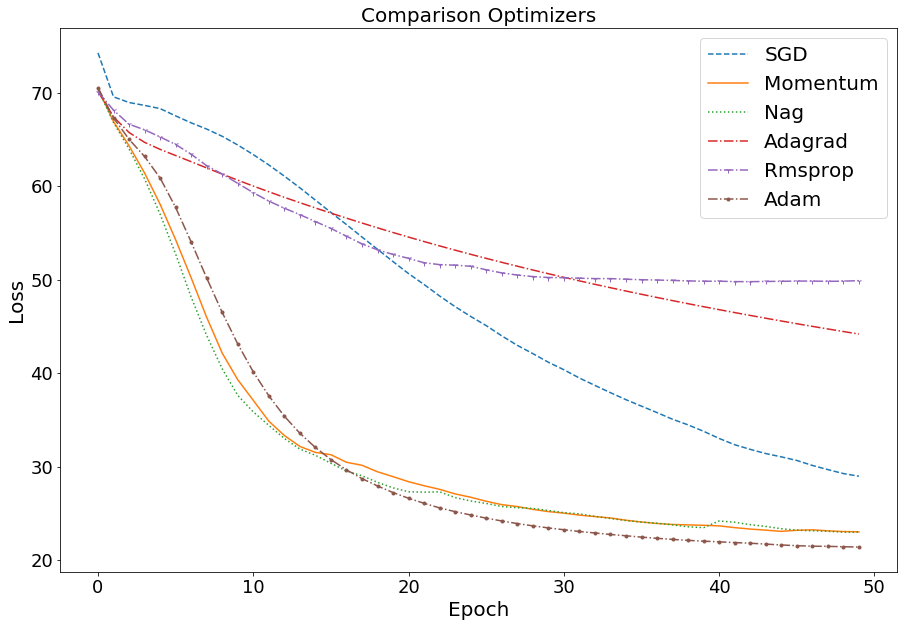

In [23]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['loss'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['loss'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['loss'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['loss'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['loss'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['loss'], linestyle= '-.', marker='.')

plt.title('Comparison Optimizers', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad','Rmsprop', 'Adam'], loc='upper right', prop={'size': 20})
plt.tick_params(labelsize=18)
plt.show()

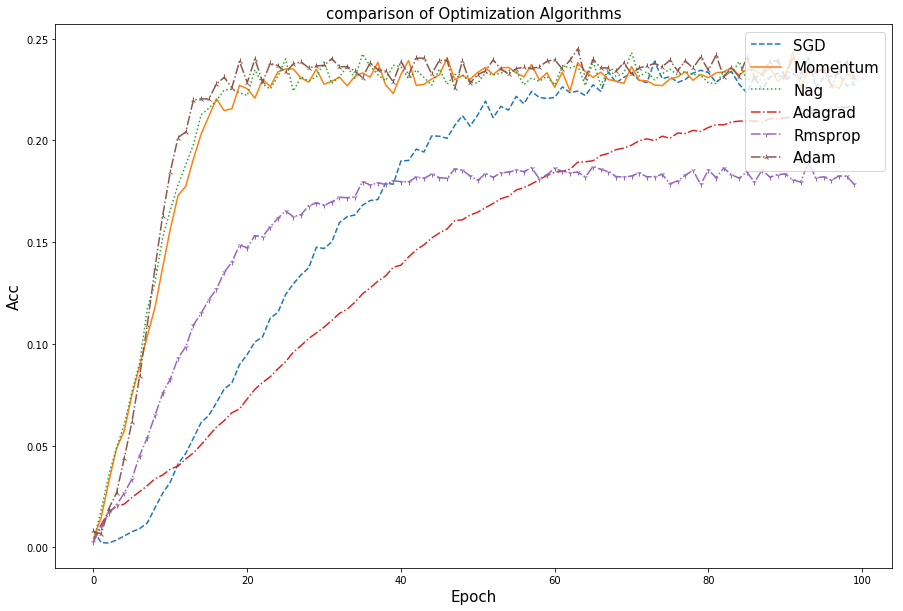

In [8]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['categorical_accuracy'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['categorical_accuracy'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['categorical_accuracy'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['categorical_accuracy'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['categorical_accuracy'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['categorical_accuracy'], linestyle= '-.', marker='2')

plt.title('comparison of Optimization Algorithms', fontsize=15)
plt.ylabel('Acc', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad','Rmsprop', 'Adam'], loc='upper right', prop={'size': 15})
plt.show()

In [100]:
K.clear_session()

my_opt_sgd = SGD(lr=0.1)

model_LSTM_100_OPT01 = Sequential()
model_LSTM_100_OPT01.add(LSTM(100, input_shape = (4, len(item2idx)))) #input_shape=(timesteps, data_dim)
model_LSTM_100_OPT01.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT01.summary()
model_LSTM_100_OPT01.compile(loss='categorical_crossentropy', optimizer=my_opt_sgd, metrics=['categorical_accuracy'])
history_LSTM_100_OPT01 = model_LSTM_100_OPT01.fit(X_train_array, Y_train_array, epochs=100, batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 10s - loss: 74.3014 - categorical_accuracy: 0.0082
Epoch 2/100
 - 9s - loss: 69.5939 - categorical_accuracy: 0.0023
Epoch 3/100
 - 9s - loss: 68.9846 - categorical_accuracy: 0.0021
Epoch 4/100
 - 9s - loss: 68.6769 - categorical_accuracy: 0.0036
Epoch 5/100
 - 9s - loss: 68.3854 - categorical_accuracy: 0.0056
Epoch 6/100
 - 9s - loss: 67.6715 - categorical_accuracy: 0.0076
Epoch 7/100
 - 9s - loss: 66.8707 - categorical_accuracy: 0.0092
Epoch 8/100
 - 9s - loss: 66.1920 - categorical_accuracy: 0.0119
Epoch 9

In [101]:
model_LSTM_100_OPT01.save('181024_model_LSTM_100h_OPT01_100e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT01_100E.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT01.history, handle)

In [1]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT01_100E.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT01 = load(handle)

In [103]:
K.clear_session()

from keras import optimizers 
momentum = optimizers.SGD(lr=0.1, momentum=0.9)

model_LSTM_100_OPT02 = Sequential()
model_LSTM_100_OPT02.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT02.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT02.summary()
model_LSTM_100_OPT02.compile(loss='categorical_crossentropy', optimizer=momentum, metrics=['categorical_accuracy'])
history_LSTM_100_OPT02 =model_LSTM_100_OPT02.fit(X_train_array, Y_train_array,  epochs=100,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 10s - loss: 70.4870 - categorical_accuracy: 0.0044
Epoch 2/100
 - 10s - loss: 67.0697 - categorical_accuracy: 0.0146
Epoch 3/100
 - 10s - loss: 64.5218 - categorical_accuracy: 0.0324
Epoch 4/100
 - 10s - loss: 61.6956 - categorical_accuracy: 0.0486
Epoch 5/100
 - 10s - loss: 58.2893 - categorical_accuracy: 0.0573
Epoch 6/100
 - 10s - loss: 54.5231 - categorical_accuracy: 0.0749
Epoch 7/100
 - 10s - loss: 50.3039 - categorical_accuracy: 0.0890
Epoch 8/100
 - 10s - loss: 46.2364 - categorical_accuracy: 0.1038


In [104]:
model_LSTM_100_OPT02.save('181024_model_LSTM_100h_OPT02_100e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT02_100E.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT02.history, handle)

In [2]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT02_100E.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT02 = load(handle)

In [106]:
K.clear_session()

nag = optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)

model_LSTM_100_OPT03 = Sequential()
model_LSTM_100_OPT03.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT03.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT03.summary()
model_LSTM_100_OPT03.compile(loss='categorical_crossentropy', optimizer=nag, metrics=['categorical_accuracy'])
history_LSTM_100_OPT03 =model_LSTM_100_OPT03.fit(X_train_array, Y_train_array,  epochs=100,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 10s - loss: 70.4231 - categorical_accuracy: 0.0029
Epoch 2/100
 - 10s - loss: 66.8927 - categorical_accuracy: 0.0183
Epoch 3/100
 - 10s - loss: 64.1108 - categorical_accuracy: 0.0356
Epoch 4/100
 - 10s - loss: 60.9682 - categorical_accuracy: 0.0489
Epoch 5/100
 - 10s - loss: 57.2525 - categorical_accuracy: 0.0604
Epoch 6/100
 - 10s - loss: 53.0008 - categorical_accuracy: 0.0765
Epoch 7/100
 - 10s - loss: 48.6194 - categorical_accuracy: 0.0905
Epoch 8/100
 - 10s - loss: 44.4937 - categorical_accuracy: 0.1173


In [107]:
model_LSTM_100_OPT03.save('181024_model_LSTM_100h_OPT03_100e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT03_100E.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT03.history, handle)

In [3]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT03_100E.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT03 = load(handle)

In [109]:
K.clear_session()

adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-6)

model_LSTM_100_OPT04 = Sequential()
model_LSTM_100_OPT04.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT04.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT04.summary()
model_LSTM_100_OPT04.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['categorical_accuracy'])
history_LSTM_100_OPT04 =model_LSTM_100_OPT04.fit(X_train_array, Y_train_array,  epochs=100,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 10s - loss: 70.1171 - categorical_accuracy: 0.0030
Epoch 2/100
 - 10s - loss: 67.3160 - categorical_accuracy: 0.0111
Epoch 3/100
 - 10s - loss: 65.7595 - categorical_accuracy: 0.0176
Epoch 4/100
 - 10s - loss: 64.7141 - categorical_accuracy: 0.0201
Epoch 5/100
 - 10s - loss: 63.8891 - categorical_accuracy: 0.0213
Epoch 6/100
 - 10s - loss: 63.1687 - categorical_accuracy: 0.0245
Epoch 7/100
 - 10s - loss: 62.5058 - categorical_accuracy: 0.0273
Epoch 8/100
 - 10s - loss: 61.8646 - categorical_accuracy: 0.0303


In [110]:
model_LSTM_100_OPT04.save('181024_model_LSTM_100h_OPT04_100e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT04_100E.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT04.history, handle)

In [4]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT04_100E.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT04 = load(handle)

In [112]:
K.clear_session()

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model_LSTM_100_OPT05 = Sequential()
model_LSTM_100_OPT05.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT05.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT05.summary()
model_LSTM_100_OPT05.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['categorical_accuracy'])
history_LSTM_100_OPT05 =model_LSTM_100_OPT05.fit(X_train_array, Y_train_array,  epochs=100,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 10s - loss: 70.1491 - categorical_accuracy: 0.0029
Epoch 2/100
 - 10s - loss: 67.9530 - categorical_accuracy: 0.0098
Epoch 3/100
 - 10s - loss: 66.7387 - categorical_accuracy: 0.0167
Epoch 4/100
 - 10s - loss: 66.1776 - categorical_accuracy: 0.0207
Epoch 5/100
 - 10s - loss: 65.4563 - categorical_accuracy: 0.0267
Epoch 6/100
 - 10s - loss: 64.6010 - categorical_accuracy: 0.0336
Epoch 7/100
 - 10s - loss: 63.6497 - categorical_accuracy: 0.0451
Epoch 8/100
 - 10s - loss: 62.6776 - categorical_accuracy: 0.0539


In [113]:
model_LSTM_100_OPT05.save('181024_model_LSTM_100h_OPT05_100e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT05_100E.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT05.history, handle)

In [5]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT05_100E.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT05 = load(handle)

In [115]:
K.clear_session()

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                      epsilon=None, decay=0.0, amsgrad=False)

model_LSTM_100_OPT06 = Sequential()
model_LSTM_100_OPT06.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT06.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT06.summary()
model_LSTM_100_OPT06.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])
history_LSTM_100_OPT06 =model_LSTM_100_OPT06.fit(X_train_array, Y_train_array,  epochs=100,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 11s - loss: 70.5630 - categorical_accuracy: 0.0079
Epoch 2/100
 - 10s - loss: 67.4541 - categorical_accuracy: 0.0066
Epoch 3/100
 - 10s - loss: 65.2101 - categorical_accuracy: 0.0191
Epoch 4/100
 - 10s - loss: 63.2985 - categorical_accuracy: 0.0268
Epoch 5/100
 - 10s - loss: 60.8227 - categorical_accuracy: 0.0438
Epoch 6/100
 - 10s - loss: 57.6077 - categorical_accuracy: 0.0616
Epoch 7/100
 - 10s - loss: 53.9328 - categorical_accuracy: 0.0840
Epoch 8/100
 - 10s - loss: 50.1610 - categorical_accuracy: 0.1093


In [116]:
model_LSTM_100_OPT06.save('181024_model_LSTM_100h_OPT06_100e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT06_100E.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT06.history, handle)

In [6]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT06_100E.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT06 = load(handle)

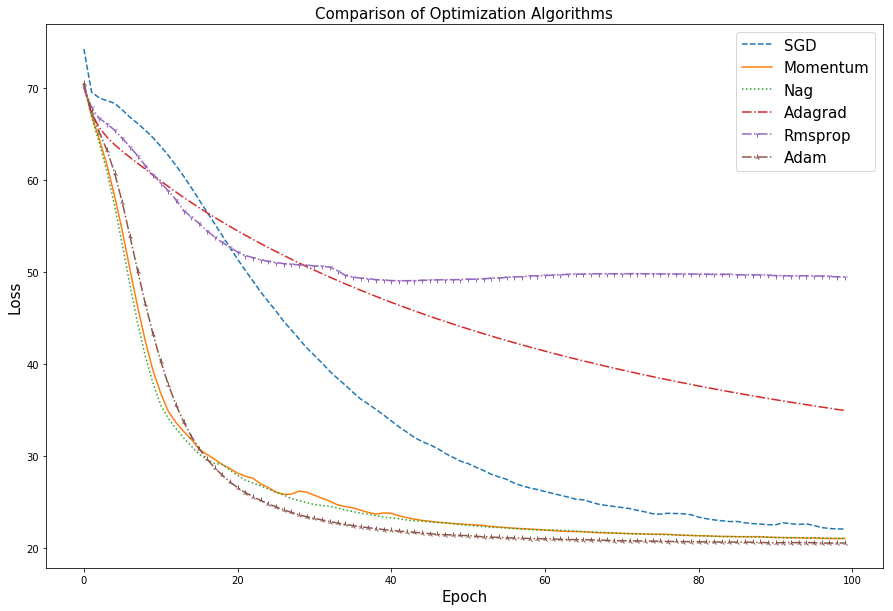

In [7]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['loss'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['loss'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['loss'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['loss'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['loss'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['loss'], linestyle= '-.', marker='2')

plt.title('Comparison of Optimization Algorithms', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad', 'Rmsprop', 'Adam'], loc='upper right', prop={'size': 15})
plt.show()

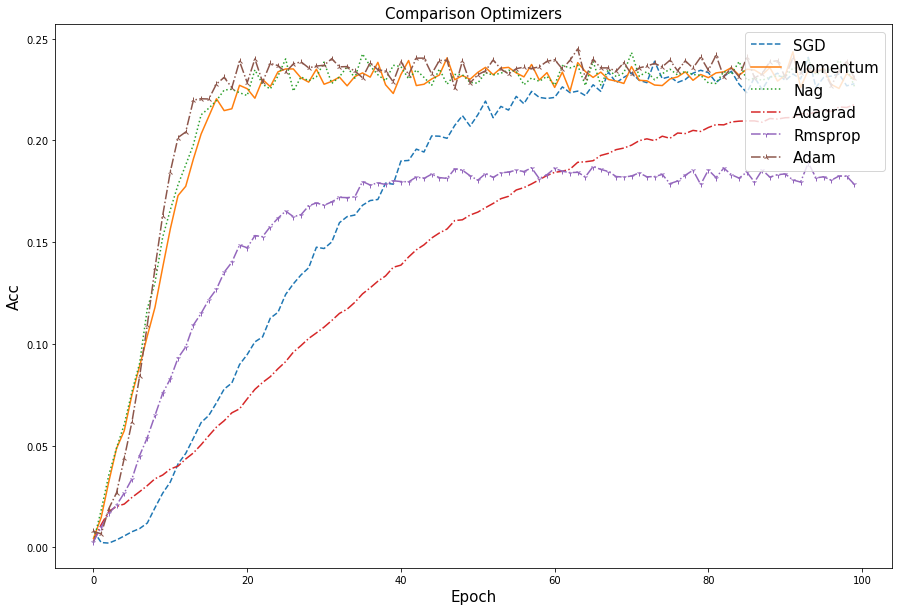

In [119]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['categorical_accuracy'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['categorical_accuracy'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['categorical_accuracy'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['categorical_accuracy'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['categorical_accuracy'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['categorical_accuracy'], linestyle= '-.', marker='2')

plt.title('Comparison Optimizers', fontsize=15)
plt.ylabel('Acc', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad','Rmsprop', 'Adam'], loc='upper right', prop={'size': 15})
plt.show()

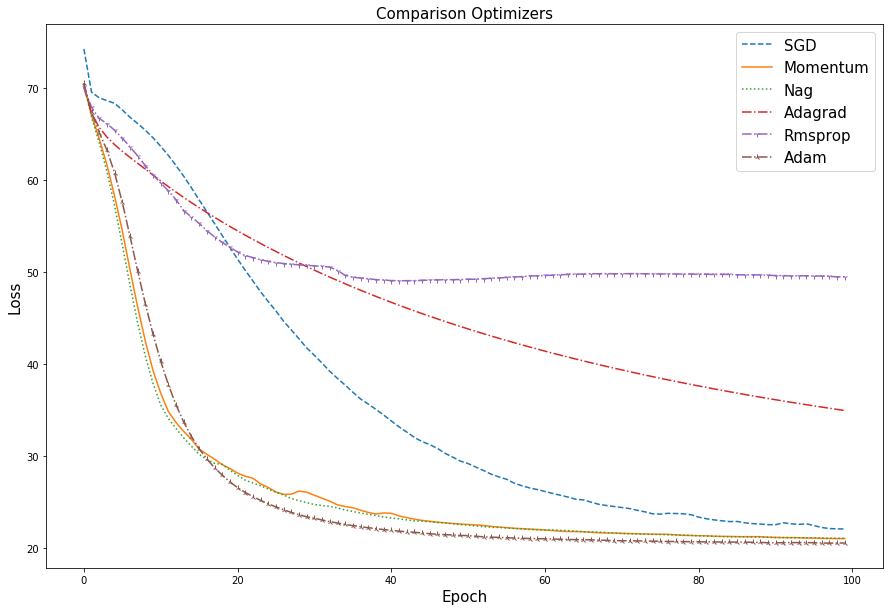

In [118]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['loss'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['loss'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['loss'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['loss'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['loss'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['loss'], linestyle= '-.', marker='2')

plt.title('Comparison Optimizers', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad','Rmsprop', 'Adam'], loc='upper right', prop={'size': 15})
plt.show()

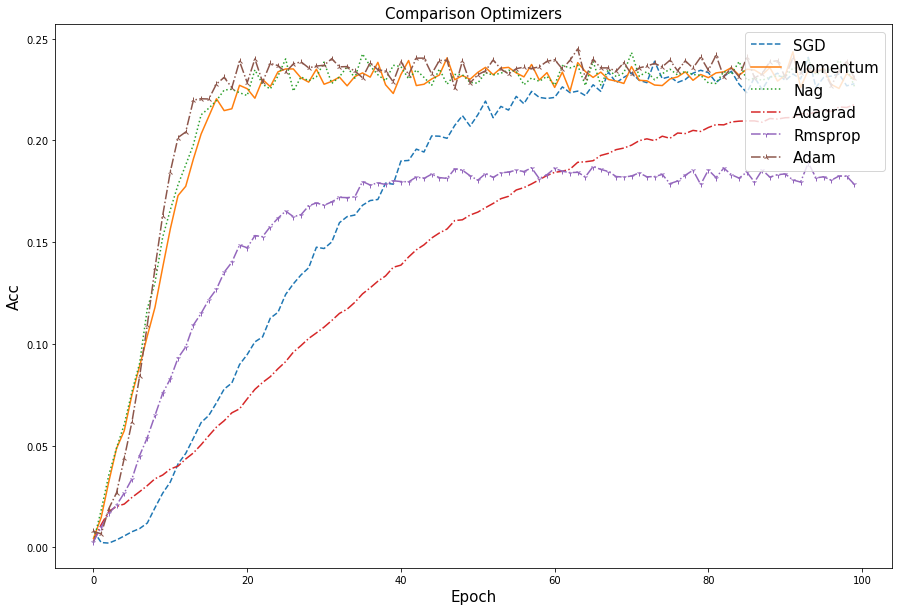

In [119]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['categorical_accuracy'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['categorical_accuracy'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['categorical_accuracy'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['categorical_accuracy'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['categorical_accuracy'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['categorical_accuracy'], linestyle= '-.', marker='2')

plt.title('Comparison Optimizers', fontsize=15)
plt.ylabel('Acc', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad','Rmsprop', 'Adam'], loc='upper right', prop={'size': 15})
plt.show()